In this notebook we will see:

1. How to tackle a classification problem
2. How to explore data and look for good/bad predictors
3. Apply logistic regression
4. Evaluate model metrics

A sample of the data can be found at: https://www.kaggle.com/fayomi/advertising.

The goal of the notebook is to explore the basic concepts of logistic regression, without diving into much details. 

In [3]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
df = pd.read_csv("/kaggle/input/advertising/advertising.csv")

In [5]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


In [6]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [7]:
df = df.dropna()

## Basic data exploration:
1. we first check that the target variable contains only 2 values
2. we check that the 2 classes are balanced

In [8]:
df["Clicked on Ad"].unique()

array([0, 1])

In [9]:
df["Clicked on Ad"].value_counts()

1    500
0    500
Name: Clicked on Ad, dtype: int64

## Relation between predictors and target variable

Is Clicked on Ad influenced heavily by any other variable?

In [10]:
# there too many countries, so we filter ahead just to give an idea of what this produce and why it'd be useful. We probably could group by continent for this to be useful
target_countries = ["Germany", "Italy", "Spain", "France"]
filtered_df= df[df.Country.isin(target_countries)]
country_counts = (filtered_df.groupby(['Country'])['Clicked on Ad']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Clicked on Ad'))
country_counts.head(10)

,Country,Clicked on Ad,percentage
1,France,0,44.444444
3,Italy,0,80.000000
0,France,1,55.555556
2,Germany,1,100.000000
4,Italy,1,20.000000
5,Spain,1,100.000000


In [11]:
df.groupby("Clicked on Ad").mean()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
Clicked on Ad,,,,,
0,76.85462,31.684,61385.58642,214.51374,0.500
1,53.14578,40.334,48614.41374,145.48646,0.462


This tells us that:
* the average age of people who clicked on the ad is higher than the ones who didn't. 
* People that spend less time on site are more likely to click on an ad. 
* Area with lower income click more on ads
* etc..

In [12]:
df.groupby("Country").mean()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
Country,,,,,,
Afghanistan,64.782500,42.125000,49014.365000,162.338750,0.250000,0.625000
Albania,63.371429,30.857143,54393.485714,173.744286,0.428571,0.571429
Algeria,66.011667,30.000000,50645.675000,176.621667,0.166667,0.500000
American Samoa,63.810000,36.800000,51222.078000,168.350000,0.200000,0.600000
Andorra,49.805000,30.000000,47165.230000,170.205000,1.000000,1.000000
...,...,...,...,...,...,...
Wallis and Futuna,71.465000,33.500000,53315.510000,199.715000,0.500000,0.250000
Western Sahara,60.132857,40.000000,52994.441429,162.835714,0.428571,0.571429
Yemen,66.850000,39.333333,54768.810000,139.343333,0.000000,0.666667


From here, we'll se if we can identify any good predictor for our Clicked on Ad variable. 

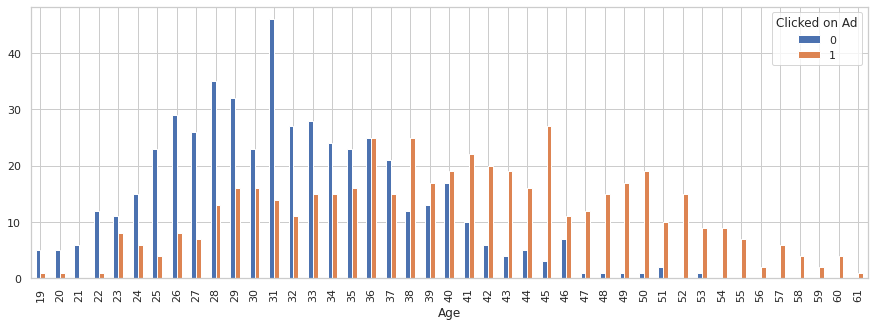

In [13]:
pd.crosstab(df["Age"],df["Clicked on Ad"]).plot(kind='bar',  figsize=(15,5))

This kind of plot tells us the frequency of clicking on an ad grouped by Age. From thi chart we could say that: older people click more than young ones. 

Age seems to be a strong predictor based on the chart above.

We can now try to bin Income and see if that is strong predictor too

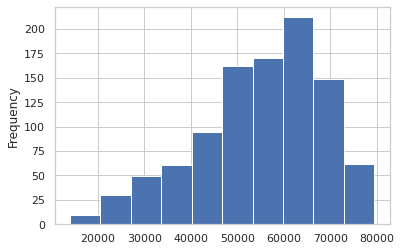

In [14]:
df["Area Income"].plot(kind="hist")

In [15]:
pd.qcut(df['Area Income'], q=4)


0        (57012.3, 65470.635]
1        (65470.635, 79484.8]
2        (57012.3, 65470.635]
3        (47031.802, 57012.3]
4        (65470.635, 79484.8]
                ...          
995      (65470.635, 79484.8]
996      (65470.635, 79484.8]
997    (13996.499, 47031.802]
998    (13996.499, 47031.802]
999    (13996.499, 47031.802]
Name: Area Income, Length: 1000, dtype: category
Categories (4, interval[float64]): [(13996.499, 47031.802] < (47031.802, 57012.3] < (57012.3, 65470.635] < (65470.635, 79484.8]]

In [16]:
df["area_income_q4"] = pd.qcut(df['Area Income'], q=4)

df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,area_income_q4
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,"(57012.3, 65470.635]"
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,"(65470.635, 79484.8]"
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,"(57012.3, 65470.635]"
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,"(47031.802, 57012.3]"
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,"(65470.635, 79484.8]"


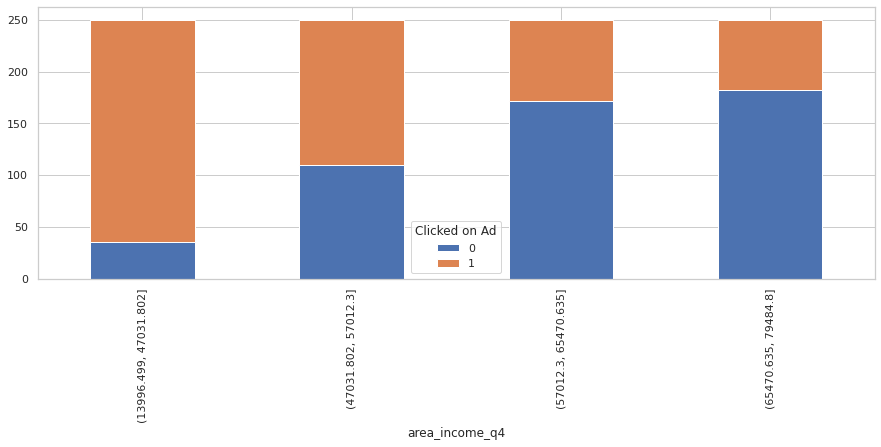

In [17]:
pd.crosstab(df["area_income_q4"],df["Clicked on Ad"]).plot(kind='bar', stacked=True, figsize=(15,5))

It looks like Area income is not a very strong predictor. 

We do the same process for time spent on site and daily internet usage

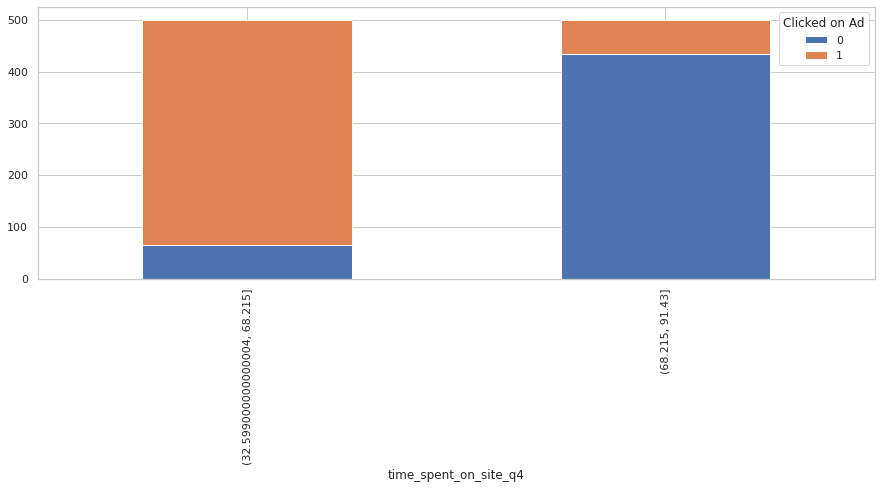

In [18]:
df["time_spent_on_site_q4"] = pd.qcut(df['Daily Time Spent on Site'], q=2)
pd.crosstab(df["time_spent_on_site_q4"],df["Clicked on Ad"]).plot(kind='bar', stacked=True, figsize=(15,5))

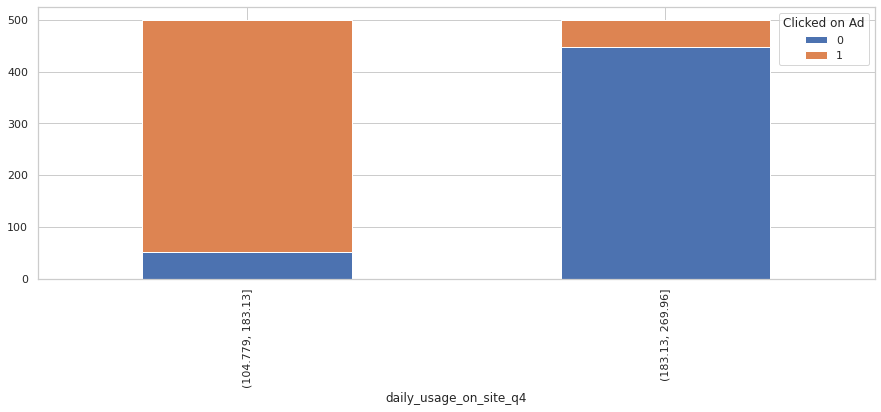

In [19]:
df["daily_usage_on_site_q4"] = pd.qcut(df['Daily Internet Usage'], q=2)
pd.crosstab(df["daily_usage_on_site_q4"],df["Clicked on Ad"]).plot(kind='bar', stacked=True, figsize=(15,5))

We will try now to fit a model, if we are not happy with the results we'll go back and create artificial variables

## Model fitting

We are going to select only a subset of the variables we analysed above and we are going to fit a simple logistic regression model

In [20]:
# we select some of the columns and split between train and test
from sklearn.model_selection import train_test_split

X = df.loc[:, ["Age", "Area Income", "Daily Internet Usage", "Daily Time Spent on Site"]]
y = df.loc[:, ['Clicked on Ad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


We now fit the model on the selected features

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

we print the predictions of our model

In [22]:
y_pred = logreg.predict(X_test)

y_pred

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

## Checking model accuracy

In [27]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
# score Return the mean accuracy on the given test data and labels

Accuracy of logistic regression classifier on test set: 0.92


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[155   9]
 [ 16 120]]


The confusion matrix tells us we have 155 + 120 correct predictions and 9 + 16 incorrect predictions

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       164
           1       0.93      0.88      0.91       136

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300



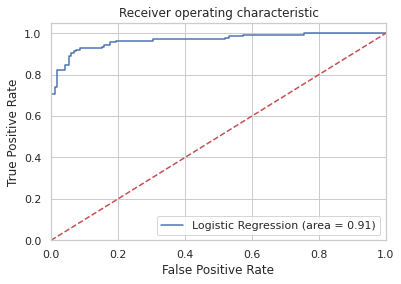

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

Let's see what happens by selecting less features

In [31]:
X = df.loc[:, ["Age", "Daily Internet Usage", "Daily Time Spent on Site"]]
y = df.loc[:, ['Clicked on Ad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
# score Return the mean accuracy on the given test data and labels



Accuracy of logistic regression classifier on test set: 0.95


In [32]:
X = df.loc[:, ["Area Income", "Daily Internet Usage", "Daily Time Spent on Site"]]
y = df.loc[:, ['Clicked on Ad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
# score Return the mean accuracy on the given test data and labels



Accuracy of logistic regression classifier on test set: 0.94
